In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
cobertura = pd.read_csv('../data/01_raw/taxa_cobertura.csv', 
                        encoding='latin1', sep=';')
cobertura = cobertura.rename(columns=str.lower)

In [3]:
cobertura['fl_regiao_metropolitana'] = cobertura['cd_rm'] != 0 & ~cobertura['cd_rm'].astype(str).str.endswith('90')
cobertura['tx_cobert_assistencia_medica'] = cobertura['tx_cobert_assistencia_medica'].str.replace(',', '.')
cobertura['tx_cobert_assistencia_medica'] = cobertura['tx_cobert_assistencia_medica'].astype(float)
cobertura['tx_cobert_assistencia_medica'] = cobertura['tx_cobert_assistencia_medica'] / 100
cobertura = cobertura[~cobertura['sg_uf'].isin(('EX', 'XX'))]

In [4]:
cities = pd.read_json(path_or_buf='../data/01_raw/citiesCensusData.json', orient='records', typ='frame', dtype=None, 
                      convert_axes=None, convert_dates=True, keep_default_dates=True, precise_float=False, 
                      date_unit=None, encoding=None, lines=False, chunksize=None, compression='infer')
cities = cities.rename(columns=str.lower)
cities['codigo'] = cities['codigo'].apply(lambda val: val // 10)

In [5]:
cities.head()

sigla  codigo     municipio  numero_de_vitimas_transito  \
0    AC  120001    ACRELANDIA                         5.0   
1    AC  120005  ASSIS BRASIL                         NaN   
2    AC  120010     BRASILEIA                         4.0   
3    AC  120013        BUJARI                         NaN   
4    AC  120017      CAPIXABA                         1.0   

   numero_de_homicidios  proporcao_de_acidentes_transito  \
0                   7.0                         0.098039   
1                   2.0                              NaN   
2                   8.0                         0.033058   
3                   5.0                              NaN   
4                   3.0                         0.025000   

   proporcao_de_homicidios  proporcao_de_suicidios  numero_de_suicidios  \
0                 0.137255                0.019608                  1.0   
1                 0.037736                     NaN                  NaN   
2                 0.066116                     NaN                  NaN   
3                 0.096154                     NaN                  NaN   
4                 0.075000                     NaN                  NaN   

   taxa_de_vitimas_transito  taxa_de_homicidios  taxa_de_suicidios  \
0                 35.410765           49.575071           7.082153   
1                       NaN           29.141775                NaN   
2                 16.453457           32.906915                NaN   
3                       NaN           52.614964                NaN   
4                  9.242144           27.726433                NaN   

   pop_considerada  renda_media regiao  
0          12519.0   294.002156  NORTE  
1           6018.0   282.648436  NORTE  
2          21262.0   331.453193  NORTE  
3           8439.0   330.311871  NORTE  
4           8798.0   332.546014  NORTE

### Agregando dados de Censo

- Ambos são identificados pelo código do município (cd_municipio x codigo)
- Alguns municipios são omitidos da base de cobertura
- Aqui consideramos a relação entre renda, violencia e adesão a seguro saúde

In [6]:
df = cobertura.groupby(['cd_municipio', 'fl_regiao_metropolitana'])[['populacao', 'benef_assistencia_medica']].sum()
df['perc_cobert_assistencia_medica'] = (df['benef_assistencia_medica'] / df['populacao'])
df['perc_cobert_assistencia_medica'] = 100 * df['perc_cobert_assistencia_medica']
df = df.reset_index()
municipios = df.copy()

In [13]:
df = municipios.merge(cities, left_on='cd_municipio', right_on='codigo', how='inner')

### Renda e Violencia

Text(0.5, 1.0, 'Demais Regiões')

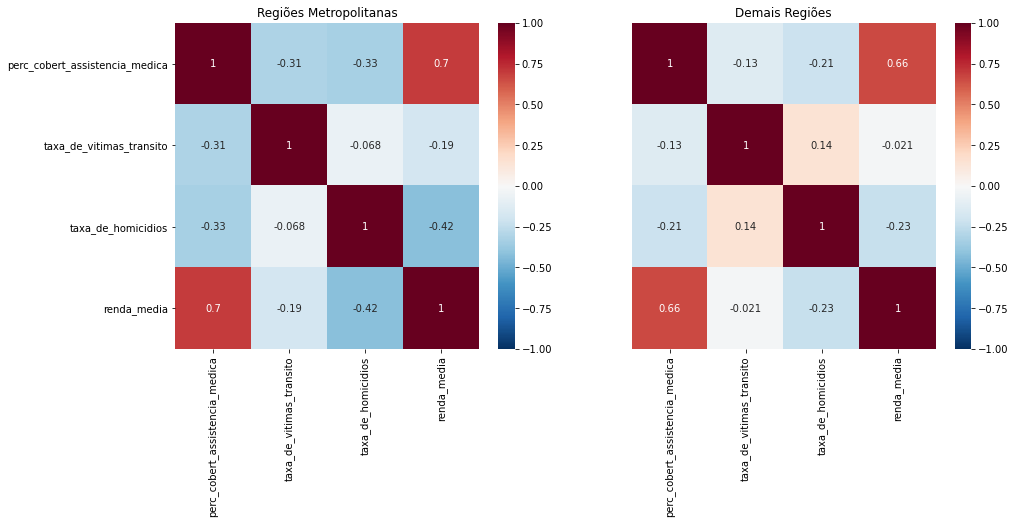

In [25]:
_, axs = plt.subplots(1, 2, figsize=(15,6))

corr = df.query('fl_regiao_metropolitana')[[
    'perc_cobert_assistencia_medica', 
    'taxa_de_vitimas_transito', 
    'taxa_de_homicidios', 
    'renda_media'
]].corr()
axs[0].set_title('Regiões Metropolitanas')
sns.heatmap(corr, vmin=-1, vmax=1, cmap='RdBu_r', annot=True, ax=axs[0])


corr = df.query('not fl_regiao_metropolitana')[[
    'perc_cobert_assistencia_medica', 
    'taxa_de_vitimas_transito', 
    'taxa_de_homicidios', 
    'renda_media'
]].corr()
sns.heatmap(corr, vmin=-1, vmax=1, cmap='RdBu_r', annot=True, ax=axs[1], yticklabels=[])
axs[1].set_title('Demais Regiões')

### Desocupação v. Cobertura

In [26]:
desocupacao_uf = pd.read_csv('../data/01_raw/desocupacao_uf_2019.csv')

In [27]:
df = cobertura.groupby(['sg_uf'])[['populacao', 'benef_assistencia_medica']].sum()
df['perc_cobert_assistencia_medica'] = (df['benef_assistencia_medica'] / df['populacao'])
df['perc_cobert_assistencia_medica'] = 100 * df['perc_cobert_assistencia_medica']
df = df.reset_index()
estados = df.copy()

estados = estados.merge(desocupacao_uf, on='sg_uf', how='left')

Text(0.5, 1.0, 'Correlação da Desocupação com Cobertura')

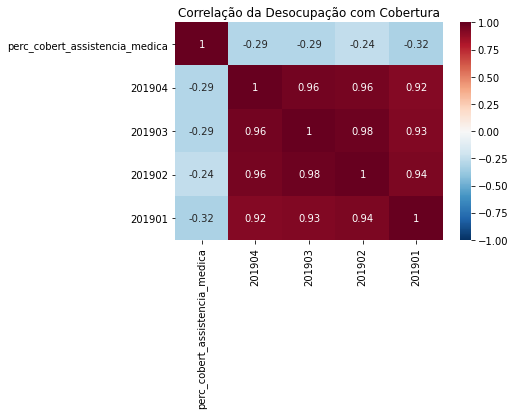

In [29]:
corr = estados[['perc_cobert_assistencia_medica', '201904', '201903', '201902', '201901']].corr()
sns.heatmap(corr, vmin=-1, vmax=1, cmap='RdBu_r', annot=True)
plt.title('Correlação da Desocupação com Cobertura')

In [31]:
df = cobertura.groupby(['sg_uf', 'fl_regiao_metropolitana'])[['populacao', 'benef_assistencia_medica']].sum()
df['perc_cobert_assistencia_medica'] = (df['benef_assistencia_medica'] / df['populacao'])
df['perc_cobert_assistencia_medica'] = 100 * df['perc_cobert_assistencia_medica']
df = df.reset_index()
estados = df.copy()

estados = estados.merge(desocupacao_uf, on='sg_uf', how='left')

Text(0.5, 1.0, 'Demais Regiões')

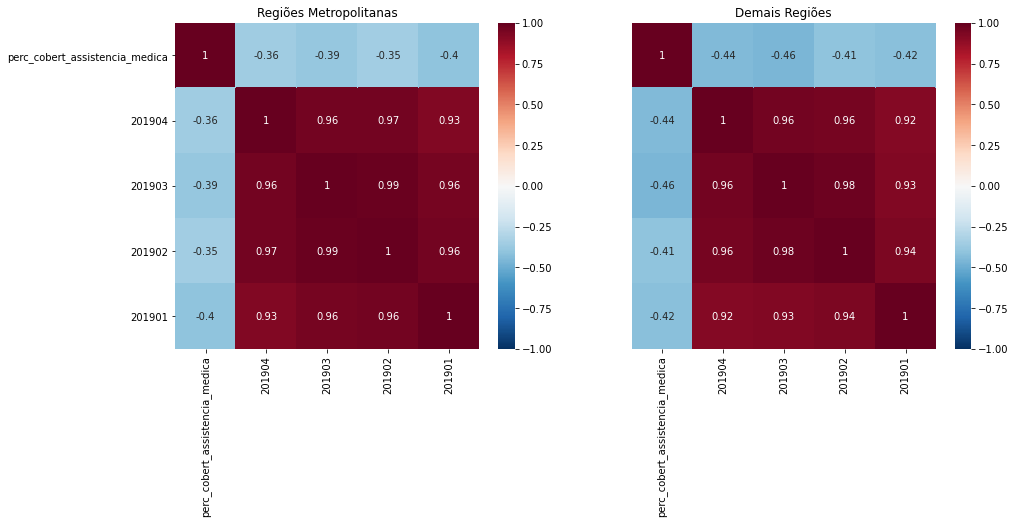

In [33]:
_, axs = plt.subplots(1, 2, figsize=(15,6))

corr = estados.query('fl_regiao_metropolitana')[[
    'perc_cobert_assistencia_medica', '201904', '201903', '201902', '201901'
]].corr()
axs[0].set_title('Regiões Metropolitanas')
sns.heatmap(corr, vmin=-1, vmax=1, cmap='RdBu_r', annot=True, ax=axs[0])


corr = estados.query('not fl_regiao_metropolitana')[[
    'perc_cobert_assistencia_medica', '201904', '201903', '201902', '201901'
]].corr()
sns.heatmap(corr, vmin=-1, vmax=1, cmap='RdBu_r', annot=True, ax=axs[1], yticklabels=[])
axs[1].set_title('Demais Regiões')